# Natural Language Processing with Disaster Tweets
## Predict which Tweets are about real disasters and which ones are not

Name: Satvik Gaikwad

MIS 612207023

EMAIL: satvikgaikwad7@gmail.com

In [88]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

# Create a directory for the logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import download
from nltk.tokenize import word_tokenize

In [90]:
download('wordnet')
download('stopwords')
download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\satvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
train_data = pd.read_csv("train.csv", encoding="utf-8")
test_data = pd.read_csv("test.csv", encoding="utf-8")

In [92]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [93]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [95]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [96]:
# fill null keywords and location with empty string
train_data["keyword"] = train_data["keyword"].fillna("")
train_data["location"] = train_data["location"].fillna("")

test_data["keyword"] = test_data["keyword"].fillna("")
test_data["location"] = test_data["location"].fillna("")
# test_data["keyword"].unique()

In [97]:
train_data["keyword"].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'dera

It is visible that each tweet has one keyword only, few keyword have "%20".
We will repalce this.

In [98]:
# replace %20 with space
train_data["keyword"] = train_data["keyword"].str.replace("%20", "")
test_data["keyword"] = train_data["keyword"].str.replace("%20", "")

In [99]:
# check if the tweets contain links
train_data["link"] = train_data["text"].str.contains("http")

test_data["link"] = test_data["text"].str.contains("http")
# test_data["link"].value_counts()


In [100]:
train_data["link"].value_counts()

link
True     3971
False    3642
Name: count, dtype: int64

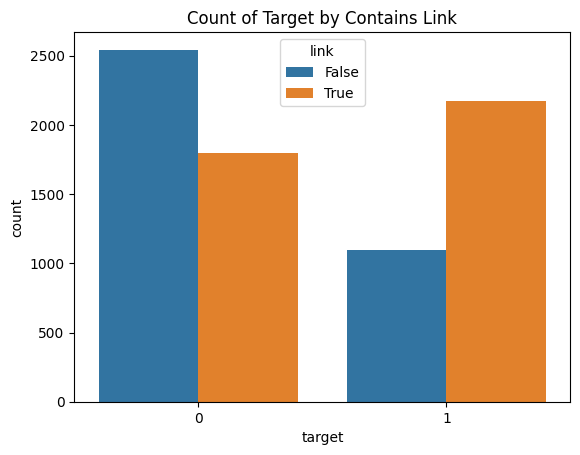

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', hue='link', data=train_data)
plt.title('Count of Target by Contains Link')
plt.show()


In [102]:
# remove those links from the tweets
train_data["text"] = train_data["text"].str.replace(r"http\S+", "<link>", regex=True)
train_data["text"] = train_data["text"].str.replace(r"www\S+", "<link>", regex=True)

test_data["text"] = test_data["text"].str.replace(r"http\S+", "<link>", regex=True)
test_data["text"] = test_data["text"].str.replace(r"www\S+", "<link>", regex=True)

In [103]:
# lowercases all the tweets
train_data["text"] = train_data["text"].str.lower()
test_data["text"] = test_data["text"].str.lower()

# replace all occurances of û_, with "<EMOJI>"
train_data["text"] = train_data["text"].str.replace("û_,", "<emoji>")
test_data["text"] = test_data["text"].str.replace("û_,", "<emoji>")

train_data["text"] = train_data["text"].str.replace("û", "<u>")
test_data["text"] = test_data["text"].str.replace("û", "<u>")

train_data["text"] = train_data["text"].str.replace("#", "hashtag")
test_data["text"] = test_data["text"].str.replace("#", "hashtag")

# replace all occurances of &amp; with and
train_data["text"] = train_data["text"].str.replace("&amp;", "and")
test_data["text"] = test_data["text"].str.replace("&amp;", "and")

# remove all punctuations
train_data["text"] = train_data["text"].str.replace(r"[^\w\s\#\@]", "")
test_data["text"] = test_data["text"].str.replace(r"[^\w\s\#\@]", "")

# Perform lemmatization
lemmatizer = WordNetLemmatizer()

exclude_lemma = ["was", "were", "is", "are", "has", "have", "had", "do", "does", "did", "news","news."]
def custom_lemmatizer(word):
  return lemmatizer.lemmatize(word) if word not in exclude_lemma else word

train_data["text"] = train_data["text"].apply(lambda x: " ".join([ custom_lemmatizer(word) for word in x.split()]))

test_data["text"] = test_data["text"].apply(lambda x: " ".join([ custom_lemmatizer(word) for word in x.split()]))

In [104]:
# remove stopwords
stop = stopwords.words('english')
train_data["text"] = train_data["text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
test_data["text"] = test_data["text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))

In [105]:
# save cleaned data to a new csv file
train_data.to_csv("train_cleaned.csv", index=False)

Till now we have cleaned and processed the data. Next we will have to tokenize the tweets and keyword

In [106]:
# tokenize the keywords and text
train_data["keyword"] = train_data["keyword"].apply(lambda x: word_tokenize(x))
train_data["text"] = train_data["text"].apply(lambda x: word_tokenize(x))
train_data.head()

test_data["keyword"] = test_data["keyword"].apply(lambda x: word_tokenize(x))
test_data["text"] = test_data["text"].apply(lambda x: word_tokenize(x))

In [107]:
train_data["length"] = train_data["text"].apply(lambda x: len(x))
test_data["length"] = test_data["text"].apply(lambda x: len(x))

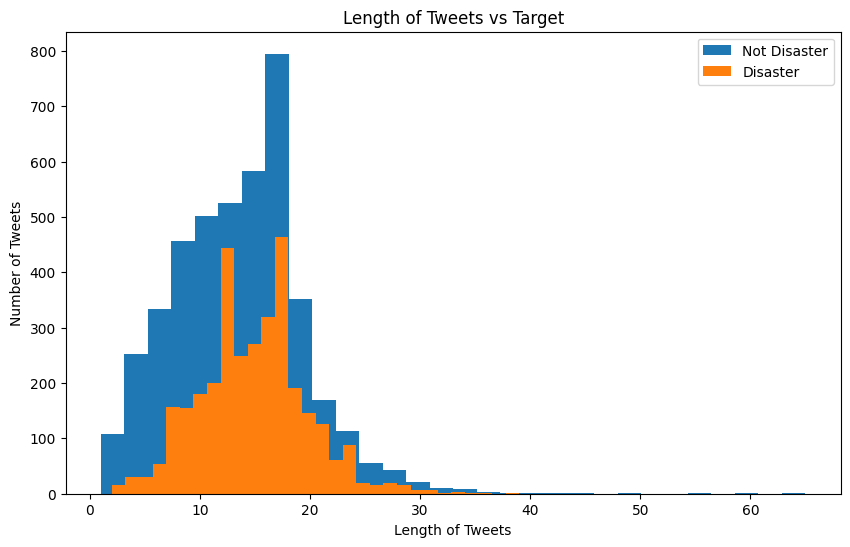

In [108]:
# plot the distribution of the length of the tweets vs target
plt.figure(figsize=(10, 6))
plt.hist(train_data[train_data["target"] == 0]["length"], bins=30, label="Not Disaster")
plt.hist(train_data[train_data["target"] == 1]["length"], bins=30, label="Disaster")
plt.legend()
plt.xlabel("Length of Tweets")
plt.ylabel("Number of Tweets")
plt.title("Length of Tweets vs Target")
plt.show()


In [109]:
# create training and validation set
train_data = train_data.drop(columns=["id", "location", "link"])
train_data.head()

,keyword,text,target,length
0,[],"[deed, reason, hashtagearthquake, may, allah, ...",1,7
1,[],"[forest, fire, near, la, ronge, sask, ., canada]",1,8
2,[],"[resident, asked, 'shelter, place, ', notified...",1,13
3,[],"[13,000, people, receive, hashtagwildfires, ev...",1,7
4,[],"[got, sent, photo, ruby, hashtagalaska, smoke,...",1,9


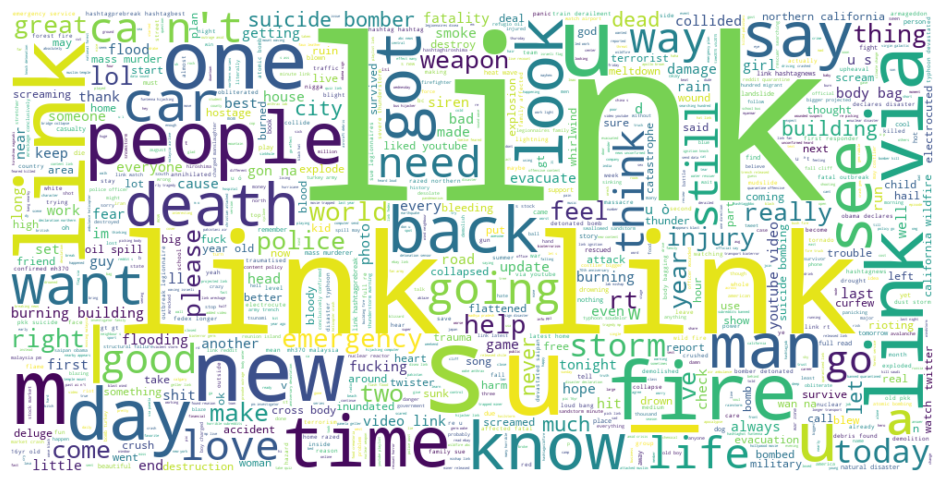

In [110]:
wc = WordCloud(background_color="white", max_words=1000, width=1000, height=500)
text_string = " ".join(" ".join(text) for text in train_data["text"].values)
wc.generate(text_string)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [111]:
training_size = int(len(train_data) * 0.80)
training_data = train_data["text"][:training_size]
training_label = train_data["target"][:training_size]
validation_data = train_data["text"][training_size:]
validation_label = train_data["target"][training_size:]

In [131]:
# Set your parameters
vocab_size = 3000 
maxlen = 50       
embedding_dim = 32
lstm_units = 128 
dropout_rate = 0.4
batch_size = 32   
epochs = 2   

# Tokenizer and padding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_data)

sequences = tokenizer.texts_to_sequences(training_data)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")

validation_sequences = tokenizer.texts_to_sequences(validation_data)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=maxlen, padding="post", truncating="post")

test_sequences = tokenizer.texts_to_sequences(test_data["text"])
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen, padding="post", truncating="post")

# Model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units // 2)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(padded, training_label, epochs=epochs, batch_size=batch_size, validation_data=(validation_padded, validation_label), callbacks=[tensorboard_callback])

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_padded, validation_label, verbose=2)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')



Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.6372 - loss: 0.6201 - val_accuracy: 0.7768 - val_loss: 0.4707
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8338 - loss: 0.3987 - val_accuracy: 0.7827 - val_loss: 0.4812
48/48 - 1s - 19ms/step - accuracy: 0.7827 - loss: 0.4812
Validation Loss: 0.48118141293525696
Validation Accuracy: 0.7826657891273499


In [113]:

# tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
# tokenizer.fit_on_texts(training_data)

# sequences = tokenizer.texts_to_sequences(training_data)
# padded = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=25, padding="post", truncating="post")

# validation_sequences = tokenizer.texts_to_sequences(validation_data)
# validation_padded = keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=25, padding="post", truncating="post")

# test_sequences = tokenizer.texts_to_sequences(test_data["text"])
# test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=25, padding="post", truncating="post")

In [114]:

# model = keras.models.Sequential([
#     keras.layers.Embedding(10000, 16, input_length=25),
#     keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
#     keras.layers.Bidirectional(keras.layers.LSTM(64)),
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1, activation="sigmoid")
# ])
# model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
# history = model.fit(padded, training_label, epochs=2, batch_size=32, validation_data=(validation_padded, validation_label))

In [115]:
# # save model to disk
# model.save("model.h5")

In [132]:
# predict on test data
predictions = model.predict(test_padded).round().astype(int)
submission = pd.DataFrame({"id": test_data["id"], "target": predictions.flatten()})
submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
